### Python script to prepare supplementary figures 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %clear
# %reset -f
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import helper_function_MMM as mmm
sns.set_style("whitegrid")
from scipy.stats import linregress
import matplotlib.gridspec as gridspec

In [3]:
%config InlineBackend.figure_format = 'svg'

### Load the collated NMR and litter mass loss data

- This dataset contains temporal NMR and chemical composition data for plant litter decomposition studies.
- Columns include study metadata, geographic coordinates, climate variables, incubation conditions, NMR region integrals, and calculated chemical properties for each sample.

In [4]:
plt.close('all')
plant_data = pd.read_excel("data/TemporalNMR_plant.xlsx")
plant_data.head()


Year                                        doi  \
0  2009.0  https://doi.org/10.1007/s10021-009-9267-z   
1  2009.0  https://doi.org/10.1007/s10021-009-9267-z   
2  2009.0  https://doi.org/10.1007/s10021-009-9267-z   
3  2009.0  https://doi.org/10.1007/s10021-009-9267-z   
4  2009.0  https://doi.org/10.1007/s10021-009-9267-z   

                                               Title                Study  \
0  Litter decomposition and humification in acidi...  Preston et al. 2009   
1  Chemical Changes During 6 Years of Decompositi...  Preston et al. 2009   
2  Chemical Changes During 6 Years of Decompositi...  Preston et al. 2009   
3  Chemical Changes During 6 Years of Decompositi...  Preston et al. 2009   
4  Chemical Changes During 6 Years of Decompositi...  Preston et al. 2009   

  site       system  source  Latitude  Longitude      ClimateCluster  ...  \
0  NaN  terrestrial  plantC   48.6118  -123.6123  Temperate_American  ...   
1  NaN  terrestrial  plantC   52.8000  -106.7000  Temperate_American  ...   
2  NaN  terrestrial  plantC   45.9000   -77.3000  Temperate_American  ...   
3  NaN  terrestrial  plantC   52.8000  -106.7000  Temperate_American  ...   
4  NaN  terrestrial  plantC   49.2000  -122.5000  Temperate_American  ...   

  F PHEN 145–165 ppm G CARBOX 165-210 ppm  Sum of all Org fractions  a  b  c  \
0              0.063                0.052                     1.000  a  b  c   
1              0.101                0.052                     0.999  a  b  c   
2              0.034                0.039                     1.001  a  b  c   
3              0.067                0.067                     1.000  a  b  c   
4              0.083                0.053                     1.000  a  b  c   

   d  e  f  g  
0  d  e  f  g  
1  d  e  f  g  
2  d  e  f  g  
3  d  e  f  g  
4  d  e  f  g  

[5 rows x 45 columns]

In [5]:
# %%

fig = px.scatter_geo(plant_data, lat='Latitude', lon='Longitude',
                     color_discrete_sequence=['red'], hover_name='Study')
fig.update_geos(projection_type="natural earth")
fig.update_layout(title_text='Your Title', margin=dict(l=0, r=0, b=0, t=0))
# fig.write_html('figs/geolocation.html', auto_open=False)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# export_params = dict(format='png', width=1200, height=800, scale=3)
# fig.write_image("figs/plantC_geolocations.png", **export_params)


In [6]:
# %%
# List all columns in plant_data DataFrame
list(plant_data.columns)

# Get unique study names as a list
study = list(plant_data['Study'].unique())

# Columns to normalize (NMR regions)
columns_to_normalize = ['A ALKYL 0–45 ppm', 'B METHOX 45–60 ppm',
                        'C O-ALKYL 60-95 ppm', 'D DI-O-ALK 95–110ppm', 'E AROM 110–145 ppm',
                        'F PHEN 145–165 ppm', 'G CARBOX 165-210 ppm']

# Normalize the selected columns by their row sum
plant_data[columns_to_normalize] = plant_data[columns_to_normalize].div(
    plant_data[columns_to_normalize].sum(axis=1), axis=0)

# Store the sum of all organic fractions for each row
plant_data["Sum of all Org fractions"] = plant_data[columns_to_normalize].sum(axis=1)

# Print the shape of the DataFrame
sz = plant_data.shape
print(sz)

# Initialize columns for molecular mixing model results and other properties
plant_data['carbohydrate_MMM'] = np.nan
plant_data['protein_MMM'] = np.nan
plant_data['lignin_MMM'] = np.nan
plant_data['lipid_MMM'] = np.nan
plant_data['carbonyl_MMM'] = np.nan
plant_data['C'] = np.nan
plant_data['N'] = np.nan
plant_data['H'] = np.nan
plant_data['O'] = np.nan
plant_data['molecularFormula'] = " "
plant_data['DR'] = np.nan
plant_data['R-squared'] = np.nan
plant_data['RMSE'] = np.nan

# Print number of missing values in C_conc and N_conc
print(plant_data['C_conc'].isna().sum())
print(plant_data['N_conc'].isna().sum())

# Fill missing C_conc values with 500
plant_data.fillna({'C_conc': 500}, inplace=True)

# Print number of missing values in C:N
print(plant_data['C:N'].isna().sum())

# Calculate N_conc from C_conc and C:N ratio
plant_data['N_conc'] = plant_data['C_conc']/plant_data['C:N']
plant_data[['C_conc', 'N_conc', 'C:N']]

# Print number of missing values in C:N after calculation
print(plant_data['C:N'].isna().sum())

# Approximate missing incubation temperature by MATC
plant_data['Incubtation T'] = plant_data['Incubtation T'].fillna(plant_data['MATC'])


(389, 45)
96
122
81
81


### Example: run molecular mixing model for a single row (index 69)


In [7]:
help(mmm.molecular_mixing_model)

Help on function molecular_mixing_model in module helper_function_MMM:

molecular_mixing_model(NMR_data)
    Molecular Mixing Model: Calculates fractions of chemical components based on NMR data.

    This model analyzes Nuclear Magnetic Resonance (NMR) spectral data and performs optimization to estimate
    the distribution of chemical components (Carbohydrate, Protein, Lignin, Lipid, Carbonyl, Char) in a
    given sample. It also computes molecular formula and oxidation state based on Carbon, Nitrogen, Hydrogen,
    and Oxygen ratios.

    #### Parameters
    - `NMR_data` (dict): Dictionary containing NMR spectral data and associated parameters. Keys include:
        - `C:N` - C:N ratio observed in the sample.
        - Spectral intensities for ppm ranges (e.g., `A ALKYL 0–45 ppm`, `B METHOX 45–60 ppm`, etc.).
        - Spectra identifiers (`a`, `b`, `c`, etc.).

    #### Returns
    - `frac` (ndarray): Fractional contribution of each chemical component.
    - `CNHO` (DataFrame): Dat

In [8]:

i = 69
NMR_data = plant_data.loc[i, :]
# NMR_data['C:N'] = np.nan
x, CNHO, simNMR, r_squared, rmse = mmm.molecular_mixing_model(NMR_data)
print(x)
print(simNMR)
print(r_squared, rmse)


[0.25886955 0.05816848 0.61204323 0.01947036 0.05144838]
[0.07898413 0.09646952 0.28276468 0.09327824 0.19057486 0.11948472
 0.08088741]
-0.21641012029818563 0.21132389082804362


### Loop through all rows and apply the molecular mixing model


In [9]:

for i in range(sz[0]):
    NMR_data = plant_data.loc[i, :]
    if not np.isnan(NMR_data['A ALKYL 0–45 ppm']):
        x, CNHO, new_mat, r_squared, rmse = mmm.molecular_mixing_model(NMR_data)
        plant_data.at[i, 'carbohydrate_MMM'] = x[0]
        plant_data.at[i, 'protein_MMM'] = x[1]
        plant_data.at[i, 'lignin_MMM'] = x[2]
        plant_data.at[i, 'lipid_MMM'] = x[3]
        plant_data.at[i, 'carbonyl_MMM'] = x[4]
        plant_data.at[i, 'C'] = CNHO['C'][0]
        plant_data.at[i, 'N'] = CNHO['N'][0]
        plant_data.at[i, 'H'] = CNHO['H'][0]
        plant_data.at[i, 'O'] = CNHO['O'][0]
        plant_data.at[i, 'molecularFormula'] = CNHO['molecularFormula'][0]
        plant_data.at[i, 'DR'] = 4-CNHO['Cox'][0]
        plant_data.at[i, 'R-squared'] = r_squared
        plant_data.at[i, 'RMSE'] = rmse
        # print(i)
print('done!')


done!


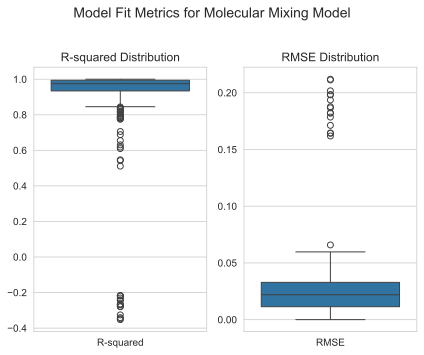

In [10]:
### Plot boxplots for R-squared and RMSE values
plt.figure(figsize=(6, 5))
plt.suptitle('Model Fit Metrics for Molecular Mixing Model', fontsize=14)
plt.subplot(1, 2, 1)
sns.boxplot(data=plant_data[['R-squared']])
plt.title('R-squared Distribution')
plt.subplot(1, 2, 2)
sns.boxplot(data=plant_data[['RMSE']])
plt.title('RMSE Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])


## preprocess data
making sure N in protein and total N in litter are consitent

Text(0, 0.5, 'protein_gN/g initial dry litter')

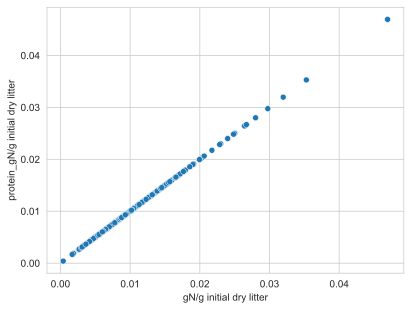

In [11]:

plant_data.columns

plant_data['carbohydrate_gC'] = 0.01*plant_data['mass remaining %']*plant_data['C_conc'] * \
    0.001*plant_data['carbohydrate_MMM']  # in gC unit/g initial dry litter
plant_data['protein_gC'] = 0.01*plant_data['mass remaining %']*plant_data['C_conc'] * \
    0.001*plant_data['protein_MMM']  # in gC unit/g initial dry litter
plant_data['lignin_gC'] = 0.01*plant_data['mass remaining %']*plant_data['C_conc'] * \
    0.001*plant_data['lignin_MMM']  # in gC unit/g initial dry litter
plant_data['lipid_gC'] = 0.01*plant_data['mass remaining %']*plant_data['C_conc'] * \
    0.001*plant_data['lipid_MMM']  # in gC unit/g initial dry litter
plant_data['carbonyl_gC'] = 0.01*plant_data['mass remaining %']*plant_data['C_conc'] * \
    0.001*plant_data['carbonyl_MMM']  # in gC unit/g initial dry litter

plant_data['totCg'] = plant_data['C_conc']*0.001*plant_data['mass remaining %']*0.01  # gC/g initial dry litter

plant_data['totNg'] = plant_data['N_conc']*0.001*plant_data['mass remaining %']*0.01  # gN/g initial dry litter


plant_data['protein_gN'] = plant_data['protein_gC']*(14*0.27/12)  # in gC unit/ g dry initial litter

plt.figure()
sns.scatterplot(plant_data, x='totNg', y='protein_gN')
plt.xlabel("gN/g initial dry litter")
plt.ylabel("protein_gN/g initial dry litter")
# plt.plot([0,0.5],[0,0.5],'k--')


### processed_data is the final table to be used for data model fitting

In [12]:
# # fill protein_gN missing values from totNg
# plant_data['protein_gN'] = plant_data['protein_gN'].fillna(plant_data['totNg'])
plant_data = plant_data[~(plant_data['R-squared'] < 0)].reset_index(drop=True)
plant_data.to_excel('data/processed_data.xlsx')
# %% get data summary



C:\Users\chak803\AppData\Local\Temp\ipykernel_31132\2910115784.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\chak803\AppData\Local\Temp\ipykernel_31132\2910115784.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



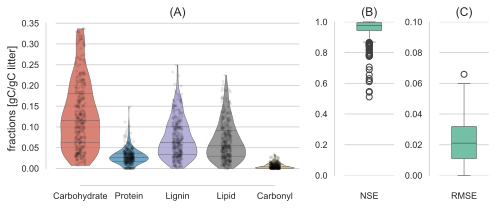

In [13]:
col = ['carbohydrate_gC', 'protein_gC', 'lignin_gC', 'lipid_gC', 'carbonyl_gC']
new_col = ['Carbohydrate [gC]', 'Protein [gC]', 'Lignin [gC]', 'Lipid [gC]', 'Carbonyl [gC]']
with plt.style.context('ggplot'):
    # Capture the active color cycle from the temporary style
    palette = sns.color_palette()
colors = palette[:len(new_col)]

plt.figure(figsize=(7,3))  # Adjust size as needed

gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 1, 1])

# Violin plots
ax1 = plt.subplot(gs[0:2])
T2_c = pd.melt(plant_data, id_vars=['Csource'], value_vars=col, var_name='NMR', value_name='C fractions')
sns.violinplot(x='NMR', y='C fractions', inner="quart", data=T2_c, hue='NMR',legend=False,
               palette=colors, alpha=0.75, linewidth=0.5, cut=0, ax=ax1)
sns.stripplot(x='NMR', y='C fractions', data=T2_c, jitter=True, color="black", size=3, alpha=0.1, ax=ax1)
ax1.set_ylabel('fractions [gC/gC litter]', fontsize=11)
ax1.set_xlabel('')
ax1.set_xticks(ticks=[0, 1, 2, 3, 4])
ax1.set_xticklabels(['Carbohydrate', 'Protein', 'Lignin', 'Lipid', 'Carbonyl'], fontsize=11)
sns.despine(offset=10, trim=True)
ax1.set_title("(A)")


# Boxplots for R-squared and RMSE
ax3 = plt.subplot(gs[2])
sns.boxplot(data=plant_data[['R-squared']], width=0.5, orient='v', ax=ax3, color = '#66CDAA', fill=True, linewidth=0.5)
ax3.set_xticklabels(['NSE'], fontsize=11)
ax3.set_ylim(0,1)
ax3.set_title("(B)")

sns.despine(offset=10, trim=True)

ax4 = plt.subplot(gs[3])
sns.boxplot(data=plant_data[['RMSE']], width=0.5, orient='v', ax=ax4, color = '#66CDAA', fill=True,linewidth=0.5)
ax4.set_xticklabels(['RMSE'], fontsize=11)
ax4.set_ylim(0,0.1)
ax4.set_title("(C)")

sns.despine(offset=10, trim=True)

for axx in [ax1,ax3,ax4]:
    axx.tick_params(axis='both', labelsize=9)
    
plt.tight_layout()
plt.savefig("figs/MMM modelfit SI figure.png", dpi=600)



### Table 1 Summary of litter types, climate, and initial litter chemical composition from the complied studies included in this analysis. 

In [14]:

rename_dict = {'carbohydrate_MMM': 'carbohydrate', 'protein_MMM': 'protein',
               'lignin_MMM': 'lignin', 'lipid_MMM': 'lipid', 'carbonyl_MMM': 'carbonyl'}

initial_plant_data = plant_data.copy()
initial_plant_data.rename(columns=rename_dict, inplace=True)


initial_plant_data['Study_SP'] = initial_plant_data['Study']+":"+initial_plant_data['Species']
initial_plant_data = initial_plant_data[~(initial_plant_data['R-squared'] < 0)].reset_index(drop=True)

incubation_length = pd.DataFrame(columns=['Study_SP', 'incubation_length'])
incubation_length = []
for sample in initial_plant_data['Study_SP'].unique():
    data = initial_plant_data[initial_plant_data['Study_SP'] == sample]
    # tempdf = pd.DataFrame({'Study_SP':sample,'incubation_length':(data['time day'].iloc[-1]-data['time day'].iloc[0])/365},index=[0])
    # incubation_length= pd.concat((incubation_length,tempdf))
    incubation_length.append((data['time day'].iloc[-1]-data['time day'].iloc[0]))

len(initial_plant_data['Study_SP'].unique())

initial_plant_data.groupby(['Csource']).count()
adf3 = initial_plant_data.groupby('Study_SP')['mass remaining %'].min()
adf3.describe()
(100-adf3).describe()

col = ['Study', 'Csource', 'Species', 'Latitude', 'Longitude', 'Climate', 'MATC', 'MAPmm', 'C_conc', 'N_conc', 'C:N', 'A ALKYL 0–45 ppm', 'B METHOX 45–60 ppm', 'C O-ALKYL 60-95 ppm',
       'D DI-O-ALK 95–110ppm', 'E AROM 110–145 ppm', 'F PHEN 145–165 ppm',
       'G CARBOX 165-210 ppm', 'carbohydrate', 'protein', 'lignin', 'lipid', 'carbonyl', 'molecularFormula', 'R-squared', 'RMSE']

initial_plant_data = initial_plant_data.loc[initial_plant_data['time day'] == 0, col]
initial_plant_data['incubation_length'] = incubation_length
# initial_plant_data.to_excel('figs/initial_plant_data.xlsx')

# Specify the columns for which you want to calculate ranges
selected_columns = ['incubation_length', 'MATC', 'MAPmm', 'C_conc', 'N_conc',
                    'C:N', 'carbohydrate', 'protein', 'lignin', 'lipid', 'carbonyl']

# Group by 'study' and calculate the min and max values for each selected column
adf = initial_plant_data.groupby('Study')[selected_columns].agg(['min', 'max']).reset_index()

# Flatten the multi-level column index
adf.columns = [' '.join(col).strip() for col in adf.columns.values]

# Rename columns to 'study', 'column_name_min', and 'column_name_max'
rename_dict = {}
for col in selected_columns:
    rename_dict[f'{col} min'] = f'min_{col}'
    rename_dict[f'{col} max'] = f'max_{col}'

adf.rename(columns=rename_dict, inplace=True)


for col in selected_columns:
    # Create a new range column for the current selected column
    range_col_name = f'{col}'
    adf[range_col_name] = ""  # Initialize the range column with empty strings
    # Iterate over rows in the DataFrame
    for index, row in adf.iterrows():
        min_val = row[f'min_{col}']
        max_val = row[f'max_{col}']
        # Format the values to display only two decimal points
        min_val_formatted = '{:1.2f}'.format(min_val)
        max_val_formatted = '{:1.2f}'.format(max_val)
        # Check if the min and max values are the same
        if min_val == max_val:
            # If they are the same, only include the single value in the range column
            adf.at[index, range_col_name] = min_val_formatted
        else:
            # If they are different, include both values separated by a dash
            adf.at[index, range_col_name] = f"{min_val_formatted} - {max_val_formatted}"

# Drop unnecessary columns
adf.drop([f'min_{col}' for col in selected_columns] + [f'max_{col}' for col in selected_columns], axis=1, inplace=True)


adf2 = initial_plant_data.groupby('Study')['Csource'].agg(lambda x: ', '.join(x.unique())).reset_index()
adf['Litter type'] = adf2['Csource']

adf2 = initial_plant_data.groupby('Study')['Climate'].agg(lambda x: ', '.join(x.unique())).reset_index()
adf['Climate'] = adf2['Climate']


adf.to_excel('figs/table1.xlsx')
print('Table 1 saved to figs/table1.xlsx')
adf.head(10)

Table 1 saved to figs/table1.xlsx


Study incubation_length   MATC    MAPmm           C_conc  \
0  Almendros et al. 2000            168.00  14.50   415.00  410.00 - 544.00   
1    Bonanomi et al 2013            180.00  16.50  1080.00  354.00 - 487.00   
2     Certini et al 2023            720.00   9.20  1273.00           500.00   
3   De Marco et al. 2021   403.00 - 810.00  16.00   756.00  487.83 - 615.09   
4         Gao et al 2016            360.00  15.50   985.00           479.80   
5          Li et al 2020            600.00  13.90   597.00  450.10 - 469.10   
6   Mathers et al., 2007            562.00  21.00   516.00  409.30 - 500.00   
7     McKee et al., 2016           1096.00  12.80   835.00           443.00   
8         Ono et al 2009           1095.00  10.70  2031.00  516.20 - 522.80   
9         Ono et al 2011           1095.00  13.70  1400.00  592.70 - 609.40   

          N_conc             C:N carbohydrate      protein       lignin  \
0   7.00 - 28.00   17.61 - 77.71  0.29 - 0.62  0.04 - 0.18  0.07 - 0.34   
1  11.30 - 35.29   12.20 - 40.10  0.36 - 0.60  0.08 - 0.26  0.03 - 0.33   
2  11.04 - 46.95   10.65 - 45.28  0.40 - 0.62  0.07 - 0.30  0.10 - 0.19   
3    4.30 - 7.25  70.70 - 124.31  0.34 - 0.43  0.03 - 0.04  0.17 - 0.25   
4           8.80           54.52         0.65         0.06         0.15   
5    8.41 - 8.61   53.52 - 54.48  0.68 - 0.75  0.06 - 0.06  0.12 - 0.13   
6   1.68 - 29.75  15.10 - 274.60  0.51 - 0.75  0.01 - 0.21  0.01 - 0.20   
7          14.70           30.14         0.67         0.11         0.01   
8  11.20 - 11.59   45.10 - 46.10  0.39 - 0.51  0.07 - 0.07  0.22 - 0.31   
9  10.62 - 11.14   53.20 - 57.40  0.37 - 0.39  0.06 - 0.06  0.24 - 0.26   

         lipid     carbonyl                            Litter type  \
0  0.07 - 0.39  0.00 - 0.07                           needle, leaf   
1  0.06 - 0.30  0.00 - 0.05                    grass, leaf, needle   
2  0.11 - 0.18  0.02 - 0.02                                  grass   
3  0.32 - 0.36  0.00 - 0.01                                   leaf   
4         0.14         0.00                            cropresidue   
5  0.06 - 0.10  0.02 - 0.03                            cropresidue   
6  0.03 - 0.27  0.01 - 0.04  cropresidue, leaf, grass, wood, roots   
7         0.18         0.03                                  grass   
8  0.20 - 0.22  0.00 - 0.00                                   leaf   
9  0.31 - 0.32  0.00 - 0.00                                   leaf   

          Climate  
0   Mediterranean  
1   Mediterranean  
2   Mediterranean  
3   Mediterranean  
4  Warm Temperate  
5  Warm Temperate  
6  Warm Temperate  
7  Warm Temperate  
8  Warm Temperate  
9  Warm Temperate

In [15]:
plant_data['O+diO_alkyl'] = plant_data[['C O-ALKYL 60-95 ppm', 'D DI-O-ALK 95–110ppm']].sum(axis=1)
plant_data['aromatic'] = plant_data[['E AROM 110–145 ppm', 'F PHEN 145–165 ppm']].sum(axis=1)
plant_data_clean = plant_data.dropna(subset=['aromatic', 'lignin_MMM'])


### Lignin vs Aromatic C Regression Plot


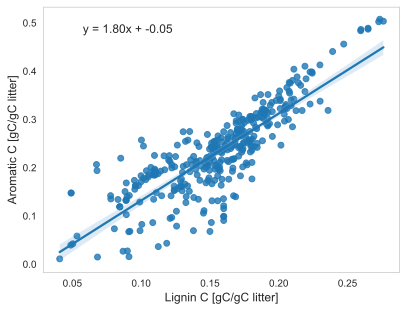

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure()
sns.regplot(plant_data_clean, y='lignin_MMM', x='aromatic')

slope, intercept, r_value, p_value, std_err = linregress(plant_data_clean['aromatic'], plant_data_clean['lignin_MMM'])

# plt.plot(plant_data_clean['lignin_MMM'],yfit, '-k')
plt.text(plt.xlim()[1]*0.2, plt.ylim()[1]*0.9, f'y = {slope:.2f}x + {intercept:.2f}', fontsize=12)
plt.ylabel('Aromatic C [gC/gC litter]', fontsize=12)
plt.xlabel('Lignin C [gC/gC litter]', fontsize=12)
plt.grid(visible=False)
plt.show()

plt.savefig("figs/lignin_vs_aromatic.png", dpi=300)


### Mass Remaining Over Time by Study and Species

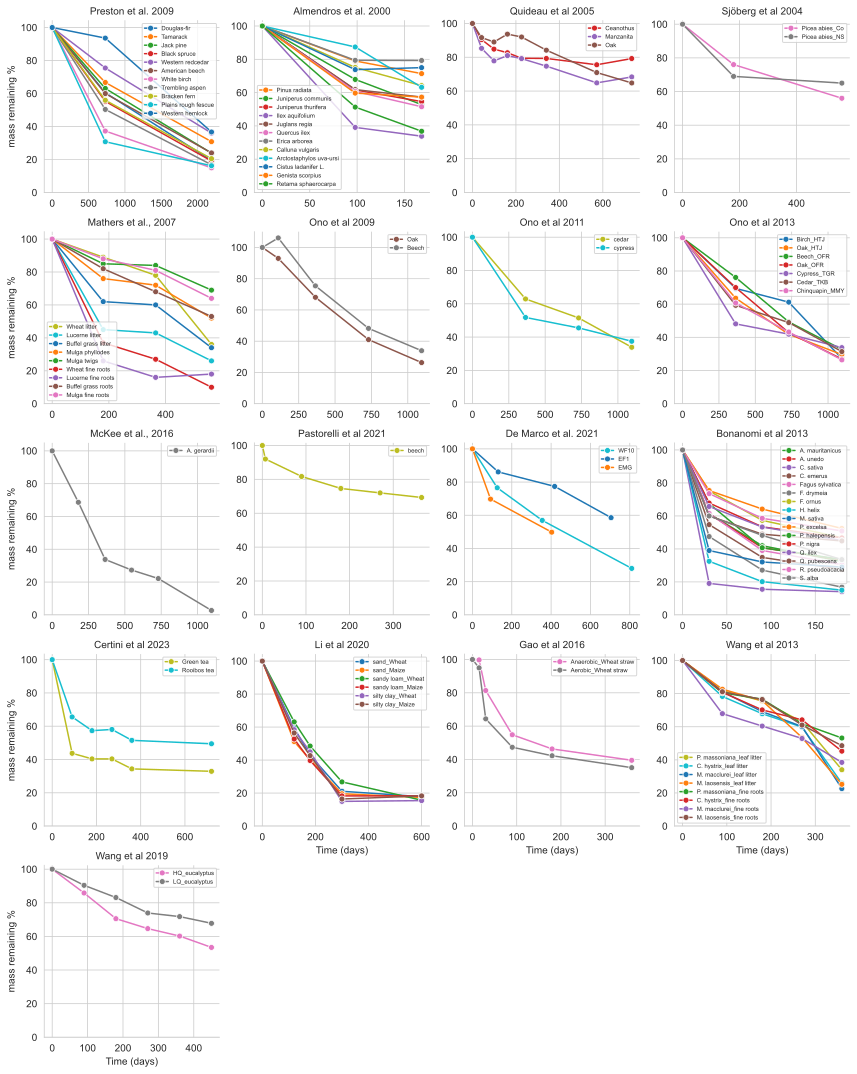

In [17]:
g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3,
                  hue='Species', palette='tab10', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='mass remaining %', marker='o')
g.set_axis_labels('Time (days)', 'mass remaining %')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
    ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()
# plt.savefig("figs/mass remaining.png", dpi=300)



### Total N (totNg) Over Time by Study and Species


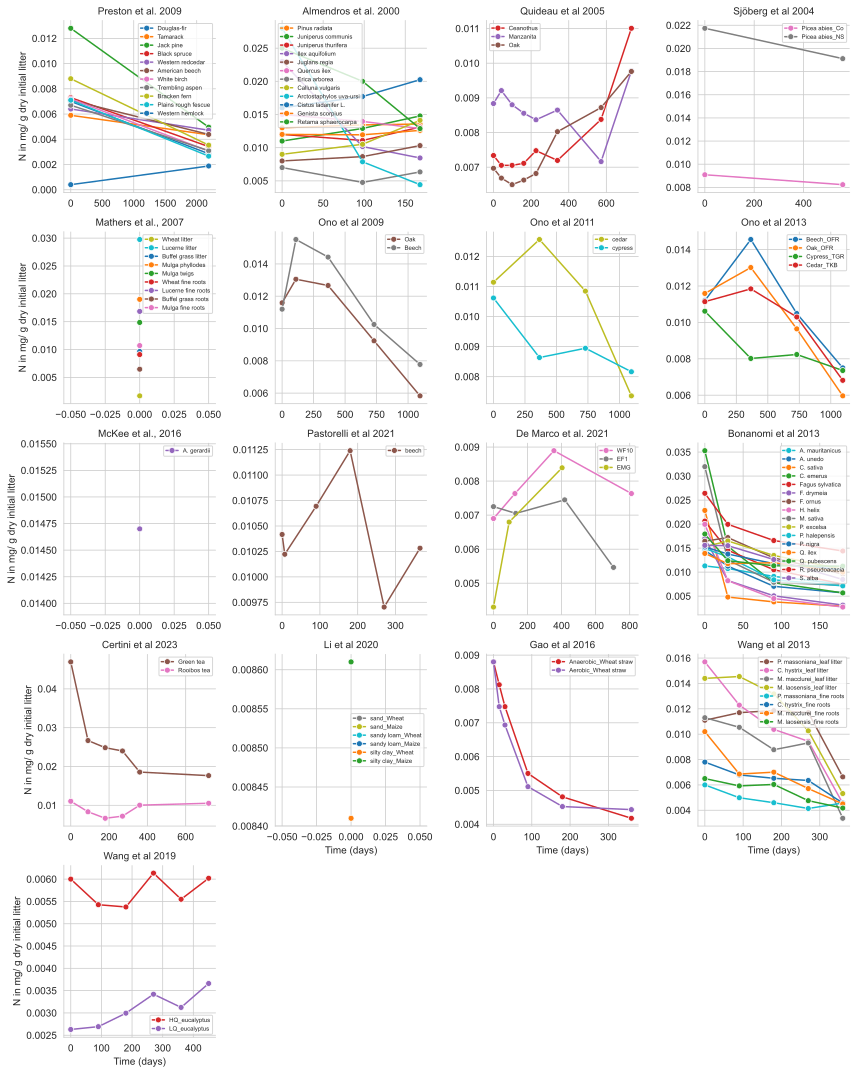

In [18]:
filtered_data = plant_data.dropna(subset=['totNg'])
g = sns.FacetGrid(filtered_data, col="Study", col_wrap=4, height=3,
                  hue='Species', palette='tab10', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='totNg', marker='o')
g.set_axis_labels('Time (days)', 'N in mg/ g dry initial litter')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend()
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/totNg.png", dpi=300)



### Protein gN Over Time by Study and Species


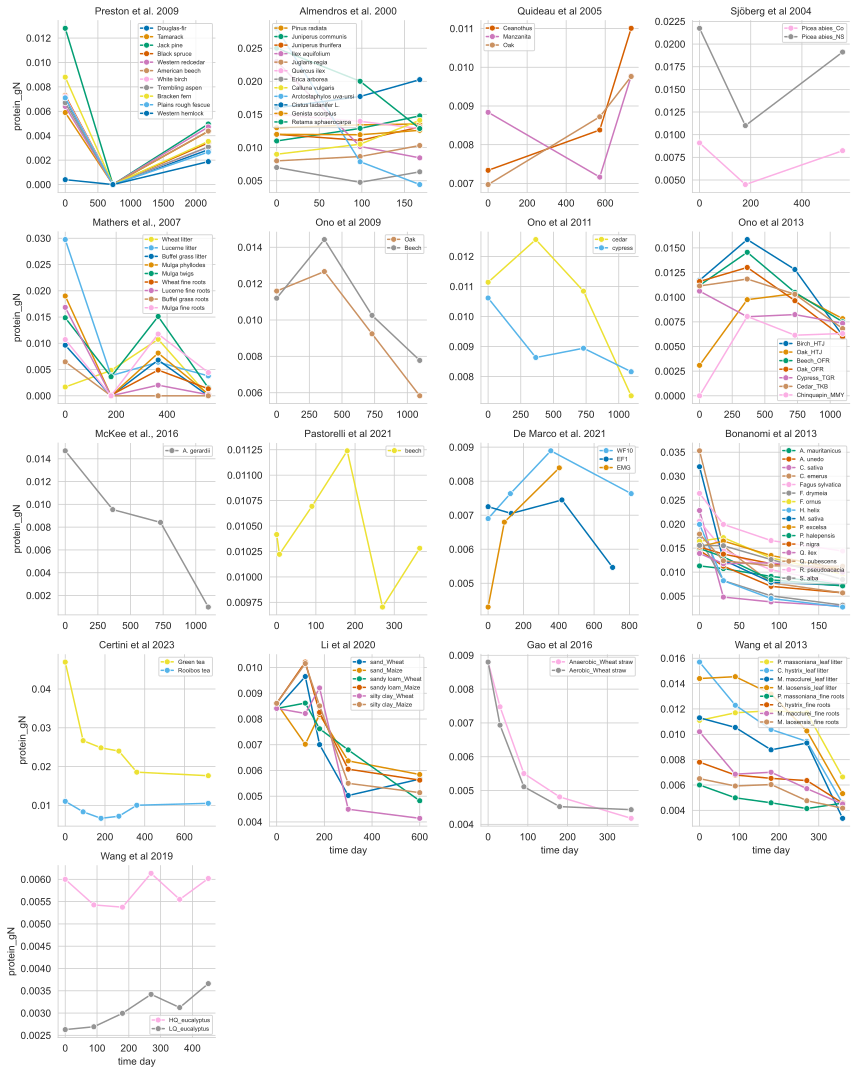

In [19]:
g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3, hue='Species',
                  palette='colorblind', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='protein_gN', marker='o')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/protein_gN.png", dpi=300)



### Carbohydrate gC Over Time by Study and Species


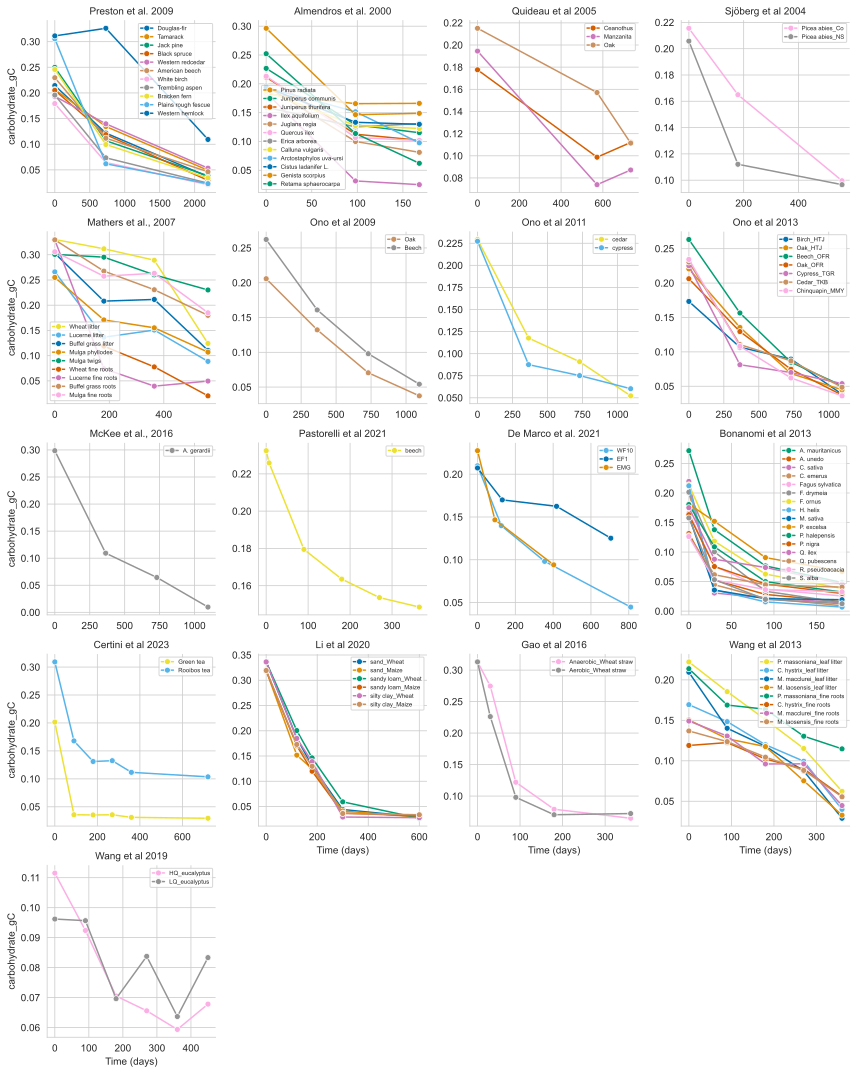

In [20]:

g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3, hue='Species',
                  palette='colorblind', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='carbohydrate_gC', marker='o')
g.set_axis_labels('Time (days)', 'carbohydrate_gC')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/carbohydrate_gC.png", dpi=300)



### Carbonyl gC Over Time by Study and Species


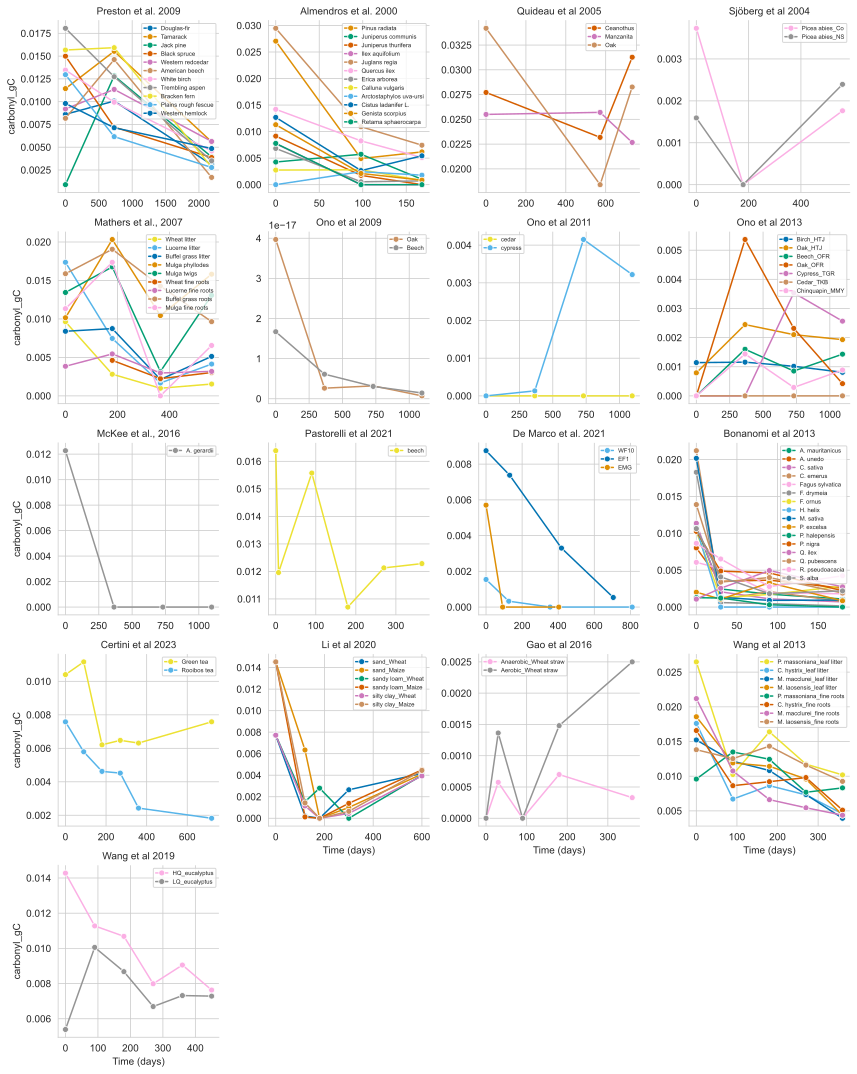

In [21]:
g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3, hue='Species',
                  palette='colorblind', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='carbonyl_gC', marker='o')
g.set_axis_labels('Time (days)', 'carbonyl_gC')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/carbonyl_gC.png", dpi=300)



### Protein gC vs Lignin gC by Study and Species


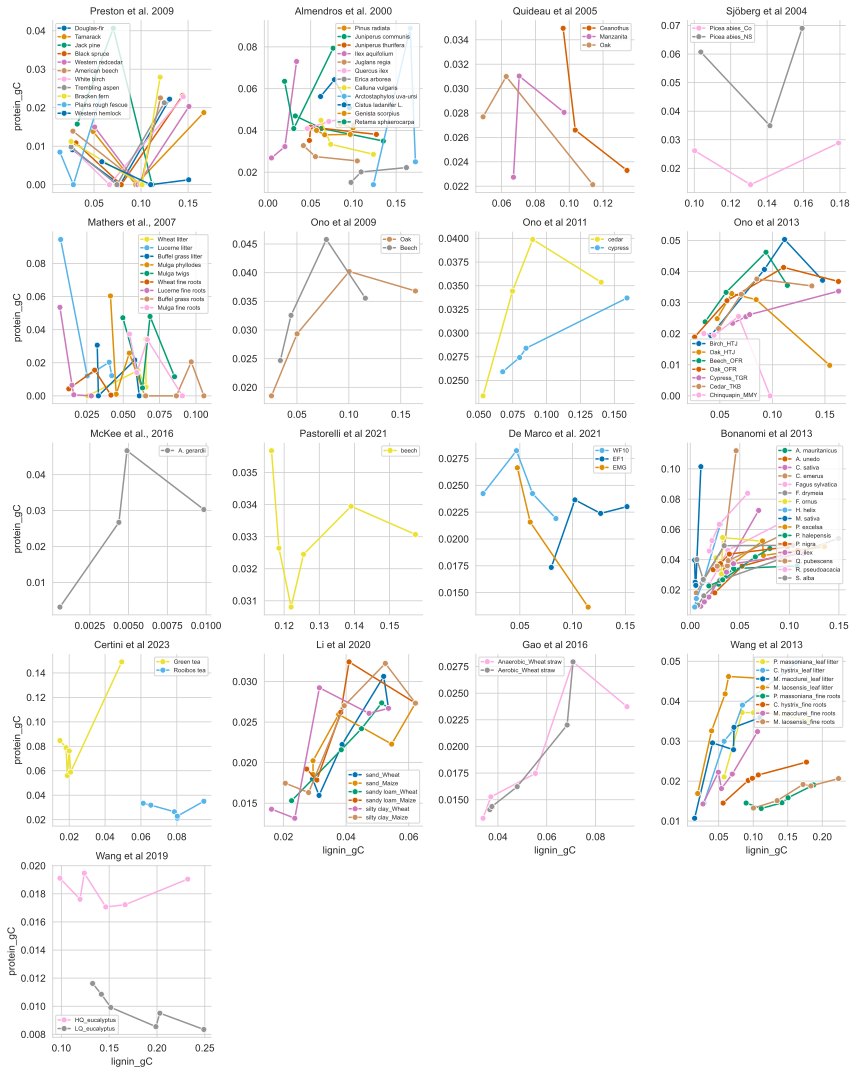

In [22]:
g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3, hue='Species',
                  palette='colorblind', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='lignin_gC', y='protein_gC', marker='o')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/protein_gC_vs_ligningC.png", dpi=300)


### Degree of Reduction Over Time by Study and Species

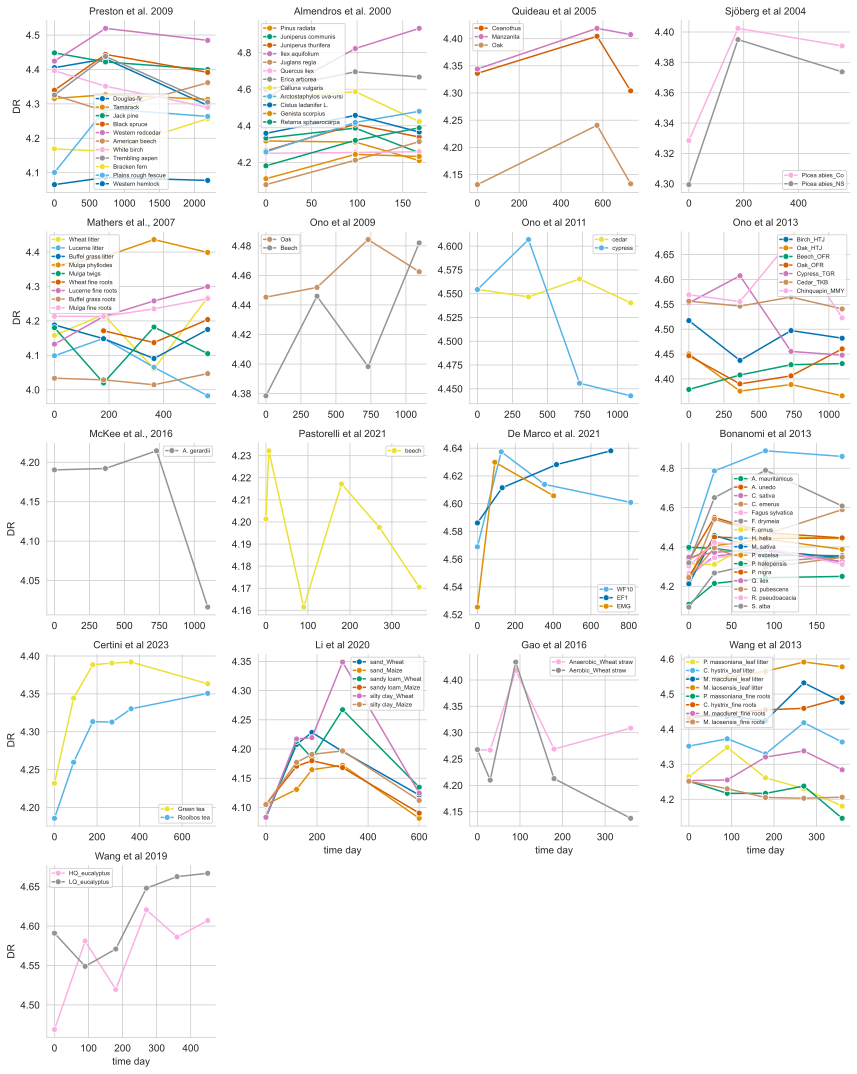

In [23]:
g = sns.FacetGrid(plant_data, col="Study", col_wrap=4, height=3, hue='Species',
                  palette='colorblind', sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='time day', y='DR', marker='o')
g.set_titles(col_template="{col_name}")
for ax in g.axes.ravel():
    ax.legend(fontsize=6)
plt.tight_layout()
plt.show()
# plt.savefig("figs/DR.png", dpi=300)
